In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import os

# Read in RockPort CSV files
directory_path = r'C:\Users\mrpro\Documents\Code\CBI\Corrected_Data_Official\nesscanResult_removedBadNesdisRecords\RockPort'
dataframes = []

for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(
            file_path,
            parse_dates=[0],
            na_values=[-999, -99, 99, 'NA', 'RM'],
            engine='python'
        )
        df.columns = ['station #', 'date', 'pwl']
        dataframes.append(df)

rp = pd.concat(dataframes, ignore_index=True)

# Read in NOAA Rockport CSV files
directory_path = r'C:\Users\mrpro\Documents\Code\CBI\data 2\NOAA\rockport'
dataframes = []

for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('level.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)

rp_NOAA = pd.concat(dataframes, ignore_index=True)

# Drop the first three rows of NOAA data, then reset index
rp_NOAA.drop(labels=range(0, 3), axis=0, inplace=True)
rp_NOAA.reset_index(drop=True, inplace=True)

# Convert date columns to datetime
rp['date'] = pd.to_datetime(rp['date'])
rp_NOAA['date'] = pd.to_datetime(rp_NOAA['Date Time'], errors='coerce')

# Merge the dataframes on date using an outer join
rp = rp.merge(rp_NOAA, on='date', how='outer')

# Drop the first two rows after merge if needed, then reset index
rp.drop(labels=range(0, 2), axis=0, inplace=True)
rp.reset_index(drop=True, inplace=True)

# Explicitly convert numeric columns
rp['pwl'] = pd.to_numeric(rp['pwl'], errors='coerce')
rp[' Water Level'] = pd.to_numeric(rp[' Water Level'], errors='coerce')

# Create offset: difference between pwl and Water Level
rp['offset'] = rp['pwl'] - rp[' Water Level']

# Drop unnecessary columns
columns_to_drop = ['Date Time', ' Sigma', ' O or I (for verified)', ' F', ' R', ' L', ' Quality ']
rp = rp.drop(columns=columns_to_drop, errors='ignore')



In [3]:
rp

,station #,date,pwl,Water Level,offset
0,015,1990-08-21 05:06:00,1.987,NaN,NaN
1,015,1990-08-21 05:12:00,1.987,NaN,NaN
2,015,1990-08-21 05:18:00,1.981,NaN,NaN
3,015,1990-08-21 05:24:00,1.984,NaN,NaN
4,015,1990-08-21 05:30:00,1.984,NaN,NaN
...,...,...,...,...,...
2876096,015,2024-12-03 21:42:00,2.084,NaN,NaN
2876097,015,2024-12-03 21:48:00,2.090,NaN,NaN
2876098,015,2024-12-16 20:30:00,2.089,NaN,NaN
2876099,015,2024-12-16 20:36:00,2.090,NaN,NaN


In [19]:
df = pd.DataFrame({
    'values': rp['offset'],
    'date': rp['date']
})

offset_list = df['values'].to_numpy()


In [20]:
offset_list

array([nan, nan, nan, ..., nan, nan, nan])

In [29]:
df = pd.DataFrame({
    'values': rp['offset'],
    'date': rp['date']
})

offset_list = df['values'].to_numpy()

def consecutive_runs_info(arr):

    if len(arr) == 0:
        return []

    runs = []
    
    def same_value(a, b):
        # True if both are NaN or if they are equal
        return (np.isnan(a) and np.isnan(b)) or (a == b)

    start_idx = 0
    current_val = arr[0]

    for i in range(1, len(arr)):
        if not same_value(arr[i], current_val):
            # We reached the end of a run, record it
            runs.append((start_idx, i, current_val, i - start_idx))
            # Start a new run
            start_idx = i
            current_val = arr[i]

    runs.append((start_idx, len(arr), current_val, len(arr) - start_idx))

    return runs

arr = offset_list
arr_rounded = np.round(arr, 3)
info = consecutive_runs_info(arr_rounded)
filtered_info = []
for (start_idx, end_idx, val, length) in info:
    if not np.isnan(val) and val !=0 and length >= 10:
        filtered_info.append((start_idx, end_idx, val, length))

print(filtered_info)
pd.DataFrame(filtered_info).to_clipboard(index=False)

[(790077, 798259, 0.008, 8182), (798269, 814719, 0.008, 16450), (814729, 819608, 0.008, 4879), (819618, 819818, 0.008, 200), (819826, 819838, 0.008, 12), (967693, 967703, 0.003, 10), (967743, 976223, 0.003, 8480), (976233, 976452, 0.003, 219), (976463, 977414, 0.003, 951), (977418, 991262, 0.003, 13844), (991792, 1000312, 0.003, 8520), (1000682, 1000692, 0.003, 10), (1003402, 1003452, 0.003, 50), (1003622, 1003632, 0.003, 10), (1006902, 1006912, 0.003, 10), (1007262, 1007272, 0.003, 10), (1008222, 1008232, 0.003, 10), (1008402, 1008412, 0.003, 10), (1012072, 1012552, 0.003, 480), (1012936, 1015912, 0.003, 2976), (1027162, 1028107, 0.003, 945), (1028584, 1028598, 0.003, 14), (1029064, 1029078, 0.003, 14), (1029542, 1029559, 0.003, 17), (1029782, 1029798, 0.003, 16), (1030982, 1030999, 0.003, 17), (1478833, 1478908, -0.013, 75), (1478959, 1479063, -0.013, 104), (1825156, 1825485, -0.002, 329), (1934416, 1934726, 0.002, 310), (1934727, 1935324, 0.002, 597), (1935325, 1935336, 0.002, 11), 

In [50]:
rp[2719820	:2733476





]

,station #,date,pwl,Water Level,offset
2719820,015,2022-06-27 16:36:00,2.067,2.052,0.015
2719821,015,2022-06-27 16:42:00,2.067,2.052,0.015
2719822,015,2022-06-27 16:48:00,2.066,2.050,0.016
2719823,015,2022-06-27 16:54:00,2.071,2.056,0.015
2719824,015,2022-06-27 17:00:00,2.069,2.054,0.015
...,...,...,...,...,...
2733471,015,2022-08-23 13:42:00,2.126,2.111,0.015
2733472,015,2022-08-23 13:48:00,2.129,2.114,0.015
2733473,015,2022-08-23 13:54:00,2.130,2.115,0.015
2733474,015,2022-08-23 14:00:00,2.133,2.118,0.015


In [31]:
rp[798250:798280]

,station #,date,pwl,Water Level,offset
798250,015,1999-10-21 21:06:00,1.989,1.981,0.008
798251,015,1999-10-21 21:12:00,1.993,1.985,0.008
798252,015,1999-10-21 21:18:00,1.993,1.985,0.008
798253,015,1999-10-21 21:24:00,1.987,1.979,0.008
798254,015,1999-10-21 21:30:00,1.988,1.980,0.008
798255,015,1999-10-21 21:36:00,1.987,1.979,0.008
798256,015,1999-10-21 21:42:00,1.985,1.977,0.008
798257,015,1999-10-21 21:48:00,1.987,1.979,0.008
798258,015,1999-10-21 21:54:00,1.985,1.977,0.008
798259,NaN,1999-10-21 22:00:00,NaN,1.977,NaN


In [28]:
df[790320:790340]

,values,date
790320,0.008,1999-09-18 20:06:00
790321,0.008,1999-09-18 20:12:00
790322,0.008,1999-09-18 20:18:00
790323,0.008,1999-09-18 20:24:00
790324,0.008,1999-09-18 20:30:00
790325,0.008,1999-09-18 20:36:00
790326,0.008,1999-09-18 20:42:00
790327,0.008,1999-09-18 20:48:00
790328,0.008,1999-09-18 20:54:00
790329,0.008,1999-09-18 21:00:00


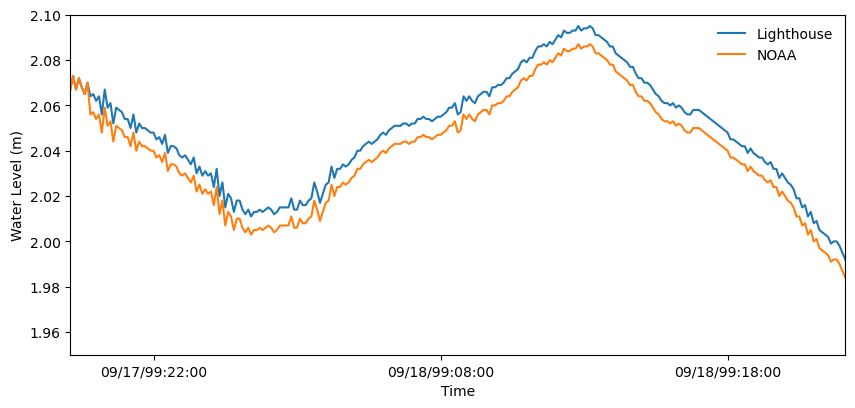

In [37]:

start_date = pd.to_datetime('9/17/1999 19:06')
end_date = pd.to_datetime('9/18/1999 22:06')

# Filter the data to only include the xlim range
filtered_data = rp[(rp['date'] >= start_date) & (rp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl'], label='Lighthouse')
plt.plot(filtered_data['date'], filtered_data[' Water Level'], label='NOAA')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=10))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(1.95, 2.1)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()